rPPG

20.0


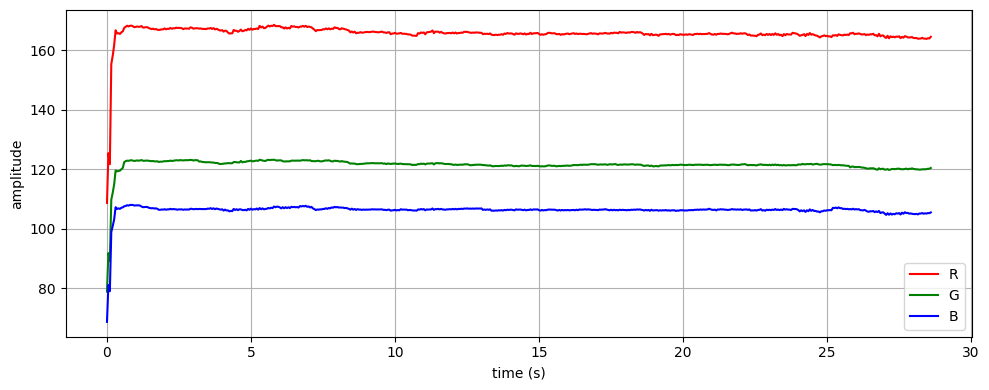

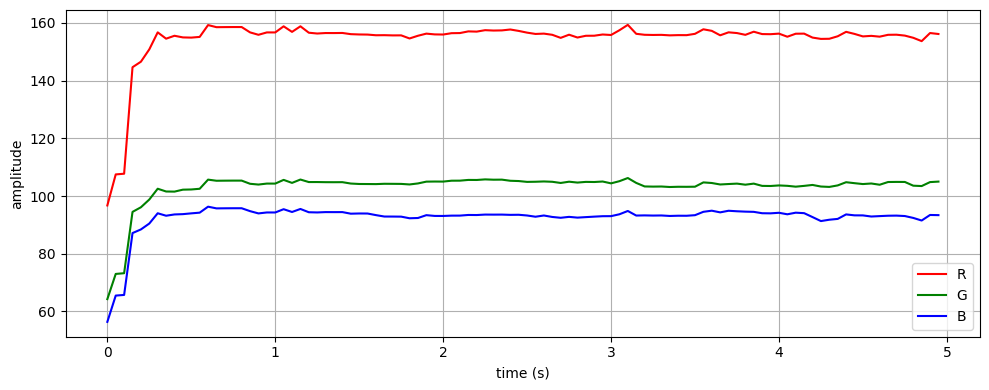

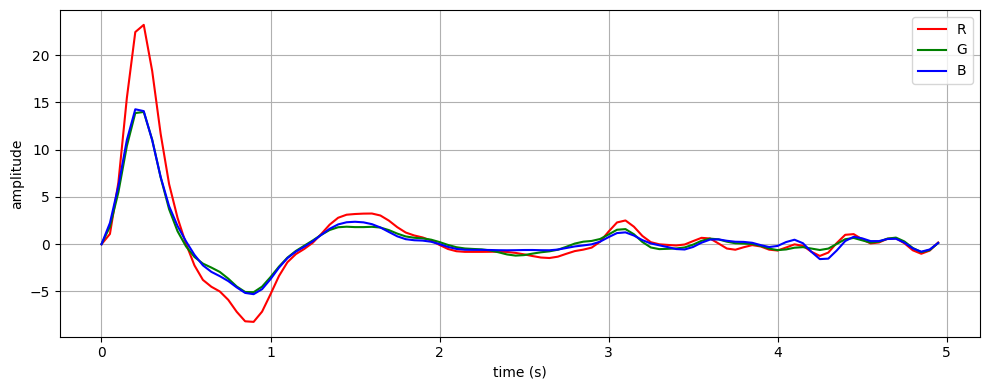

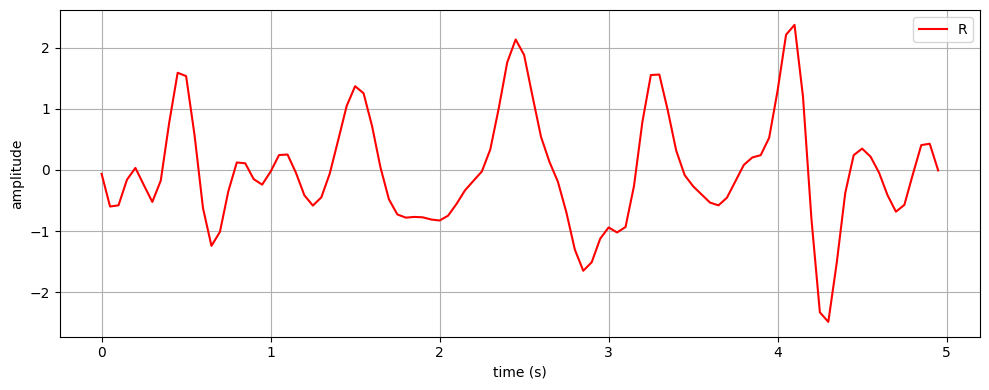

[53.61328125 67.08984375 66.2109375  67.96875    61.81640625 63.57421875
 61.23046875 61.81640625 68.84765625 67.08984375 65.625      68.5546875
 64.16015625 63.57421875 65.0390625  65.625      62.98828125 59.765625
 57.421875   64.16015625 66.2109375  69.140625   74.70703125 72.0703125 ]


In [1]:
import configparser
import ast
from numpy.lib.arraysetops import isin
import cv2
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import plotly.graph_objects as go
from importlib import import_module, util
from pyVHR.extraction.sig_processing import *
from pyVHR.extraction.sig_extraction_methods import *
from pyVHR.extraction.skin_extraction_methods import *
from pyVHR.BVP.BVP import *
from pyVHR.BPM.BPM import *
from pyVHR.BVP.methods import *
from pyVHR.BVP.filters import *
import time
from inspect import getmembers, isfunction
import os.path


videoFileName = 'output.avi'

# params
window_size = 5 #seconds
roi_approach = 'patches'   # 'hol' or 'patches'
#roi_approach = 'hol'   # 'hol' or 'patches'
bpm_est = 'medians'     # BPM final estimate, if patches choose 'medians' or 'clustering'
method = 'cpu_CHROM'       # one of the methods implemented in pyVHR
#method = 'cpu_ICA'       # one of the methods implemented in pyVHR
roi_method = 'convexhull'
#roi_method = 'faceparsing' 
bpm_type = 'welch'
#bpm_type = 'psd_clustering'
pre_filt = True
post_filt = True

ldmks_list = [2, 3, 4, 5, 6, 8, 9, 10, 18, 21, 32, 35, 36, 43, 46, 47, 48, 50, 54, 58, 67, 68, 69, 71, 92, 93, 101, 103, 104, 108, 109, 116, 117, 118, 123, 132, 134, 135, 138, 139, 142, 148, 149, 150, 151, 152, 182, 187, 188, 193, 197, 201, 205, 206, 207, 210, 211, 212, 216, 234, 248, 251, 262, 265, 266, 273, 277, 278, 280, 284, 288, 297, 299, 322, 323, 330, 332, 333, 337, 338, 345, 346, 361, 363, 364, 367, 368, 371, 377, 379, 411, 412, 417, 421, 425, 426, 427, 430, 432, 436]
assert os.path.isfile(videoFileName), "\nThe provided video file does not exists!"

sig_processing = SignalProcessing()
av_meths = getmembers(pyVHR.BVP.methods, isfunction)
available_methods = [am[0] for am in av_meths]

assert method in available_methods,  f"\nrPPG method '{method}' not recognized!! Available methods: {', '.join(available_methods)}"


# set skin extractor
if roi_method == 'convexhull':
    sig_processing.set_skin_extractor(
        SkinExtractionConvexHull())
elif roi_method == 'faceparsing':
    sig_processing.set_skin_extractor(
        SkinExtractionFaceParsing())
else:
    raise ValueError("Unknown 'roi_method'")

assert roi_approach == 'patches' or roi_approach=='hol', "\nROI extraction approach not recognized!"

# set patches
if roi_approach == 'patches':
    sig_processing.set_landmarks(ldmks_list)
    # set squares patches side dimension
    sig_processing.set_square_patches_side(28.0)

# set sig-processing and skin-processing params
SignalProcessingParams.RGB_LOW_TH = 75
SignalProcessingParams.RGB_HIGH_TH = 230
SkinProcessingParams.RGB_LOW_TH = 75
SkinProcessingParams.RGB_HIGH_TH = 230

fps = get_fps(videoFileName)
print(fps)
sig_processing.set_total_frames(0)

# -- ROI selection
sig = []
if roi_approach == 'hol':
    # SIG extraction with holistic
    sig = sig_processing.extract_holistic(videoFileName)
elif roi_approach == 'patches':
    # SIG extraction with patches
    sig = sig_processing.extract_patches(videoFileName, 'squares', 'mean')

#print(np.shape(sig))

sample = np.mean(sig, axis=1)  

#print(np.shape(sample))


t = np.arange(np.shape(sample)[0]) / fps  

plt.figure(figsize=(10, 4))
plt.plot(t,sample[:, 0], label='R', color='r')
plt.plot(t,sample[:, 1], label='G',  color='g')
plt.plot(t,sample[:, 2], label='B',  color='b')
plt.xlabel("time (s)")
plt.ylabel("amplitude")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# -- sig windowing
windowed_sig, timesES = sig_windowing(sig, window_size, 1, fps)



# -- color threshold - applied only with patches
if roi_approach == 'patches':
    windowed_sig = apply_filter(windowed_sig,
                                            rgb_filter_th,
                                            params={'RGB_LOW_TH':  75,
                                                    'RGB_HIGH_TH': 230})
'''
print(len(windowed_sig))
for i in range(0,len(windowed_sig)):
    sample = windowed_sig[i]
    print(np.shape(sample))
'''

sample = windowed_sig[0][0]
t = np.arange(np.shape(sample)[1]) / fps  

plt.figure(figsize=(10, 4))
plt.plot(t,sample[0,:], label='R', color='r')
plt.plot(t,sample[1,:], label='G',  color='g')
plt.plot(t,sample[2,:], label='B',  color='b')
plt.xlabel("time (s)")
plt.ylabel("amplitude")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

if pre_filt:
    module = import_module('pyVHR.BVP.filters')
    method_to_call = getattr(module, 'BPfilter')
    windowed_sig = apply_filter(windowed_sig, 
                        method_to_call, 
                        fps=fps, 
                        params={'minHz':0.65, 'maxHz':4.0, 'fps':'adaptive', 'order':6})

'''
for i in range(0,len(windowed_sig)):
    sample = windowed_sig[i]
    print(np.shape(sample))
'''

sample = windowed_sig[0][0]
t = np.arange(np.shape(sample)[1]) / fps  

plt.figure(figsize=(10, 4))
plt.plot(t,sample[0,:], label='R', color='r')
plt.plot(t,sample[1,:], label='G',  color='g')
plt.plot(t,sample[2,:], label='B',  color='b')
plt.xlabel("time (s)")
plt.ylabel("amplitude")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# -- BVP Extraction
module = import_module('pyVHR.BVP.methods')
method_to_call = getattr(module, method)
if 'cpu' in method:
    method_device = 'cpu'


if 'POS' in method:
    pars = {'fps':'adaptive'}
elif 'PCA' in method or 'ICA' in method:
    pars = {'component': 'all_comp'}
else:
    pars = {}

bvps = RGB_sig_to_BVP(windowed_sig, fps,
                        device_type=method_device, method=method_to_call, params=pars)

'''print(len(bvps))
for i in range(0,len(bvps)):
    sample = bvps[i]
    print(np.shape(sample))
'''
sample = bvps[0][0]

t = np.arange(np.shape(sample)[0]) / fps  

plt.figure(figsize=(10, 4))
plt.plot(t,sample, label='R', color='r')
plt.xlabel("time (s)")
plt.ylabel("amplitude")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# -- POST FILTERING
if post_filt:
    module = import_module('pyVHR.BVP.filters')
    method_to_call = getattr(module, 'BPfilter')
    bvps = apply_filter(bvps, 
                        method_to_call, 
                        fps=fps, 
                        params={'minHz':0.65, 'maxHz':4.0, 'fps':'adaptive', 'order':6})


# -- BPM Estimation
if bpm_type == 'welch':
        bpmES = BVP_to_BPM(bvps, fps, minHz=0.65, maxHz=4.0)
elif bpm_type == 'psd_clustering':
        bpmES = BVP_to_BPM_PSD_clustering(bvps, fps, minHz=0.65, maxHz=4.0)
else:
    raise ValueError("Unknown 'bpm_type'")

# median BPM from multiple estimators BPM
median_bpmES, mad_bpmES = multi_est_BPM_median(bpmES)

print(median_bpmES)


In [9]:
from pyVHR.plot.visualize import *

window = 1

visualize_windowed_sig(windowed_sig, window)

visualize_BVPs(bvps, window)

visualize_BVPs_PSD(bvps, window, fps, minHz=0.65, maxHz=4.0)